In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import numpy as np
import matplotlib.pyplot as plt

from seirsplus.calibration import _get_vl_with_plateau, gen_vl_distribution_with_plateau

In [42]:
# convert critical Ct values in Brault Table 1 to log10 VL
# TODO: the tail plateau seems pretty high, I think it should be somewhat smaller

def Ct_to_VL(Ct):
    return (14 + np.log10(1.105))-0.681/(np.log(10))*Ct

print(Ct_to_VL(22.6), Ct_to_VL(33.6), Ct_to_VL(20.1), Ct_to_VL(29.4), Ct_to_VL(34.8))

7.359309624840942 4.106009660903684 8.098695980281228 5.348178738043364 3.751104210292347


## Test the function for generating a single trajectory of expected viral load values over time

In [57]:
critical_time_points = [5, 7, 11, 16]
peak_plateau_height = 7.359
tail_plateau_height = 4.106

vls = []
sample_times = np.linspace(0, 20, 41)

for sample_time in sample_times:
    vls.append(_get_vl_with_plateau(
        critical_time_points,
        peak_plateau_height,
        tail_plateau_height,
        sample_time
    ))


Text(0.5, 1.0, 'Example expected viral load over time with plateau')

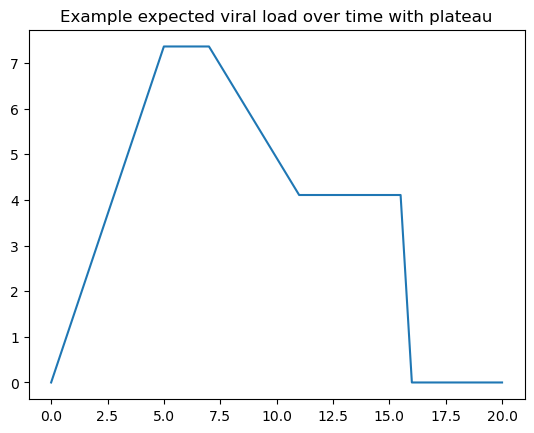

In [58]:

plt.plot(sample_times, vls)
plt.title("Example expected viral load over time with plateau")

## Test the function for sampling viral loads of a population

with noise added, i.e., VL_i(t) | params = E[VL(t) | params] + N(0, noise)

In [4]:
def get_gmm_samples(
    n_samples = 10000,
    weights = [0.33, 0.54, 0.13],
    means = [8.09, 5.35, 3.75],
    sigmas = [1.06, 0.89, 0.39]
):
    gmm_samples = np.random.normal(
        loc = np.random.choice(means, size=n_samples, p=weights),
        scale = np.random.choice(sigmas, size=n_samples, p=weights)
    )
    return gmm_samples

(array([  1.,   0.,   1.,   1.,   0.,   2.,   1.,   7.,   5.,  17.,  21.,
         28.,  51.,  65., 111., 150., 216., 237., 323., 321., 402., 488.,
        490., 628., 668., 630., 539., 395., 360., 318., 272., 255., 269.,
        336., 341., 362., 378., 349., 275., 209., 154., 119.,  82.,  63.,
         24.,  15.,  11.,   5.,   2.,   3.]),
 array([-0.5217942 , -0.28333538, -0.04487655,  0.19358227,  0.4320411 ,
         0.67049993,  0.90895875,  1.14741758,  1.3858764 ,  1.62433523,
         1.86279406,  2.10125288,  2.33971171,  2.57817053,  2.81662936,
         3.05508819,  3.29354701,  3.53200584,  3.77046466,  4.00892349,
         4.24738232,  4.48584114,  4.72429997,  4.96275879,  5.20121762,
         5.43967645,  5.67813527,  5.9165941 ,  6.15505292,  6.39351175,
         6.63197058,  6.8704294 ,  7.10888823,  7.34734705,  7.58580588,
         7.82426471,  8.06272353,  8.30118236,  8.53964118,  8.77810001,
         9.01655884,  9.25501766,  9.49347649,  9.73193531,  9.97039414,
 

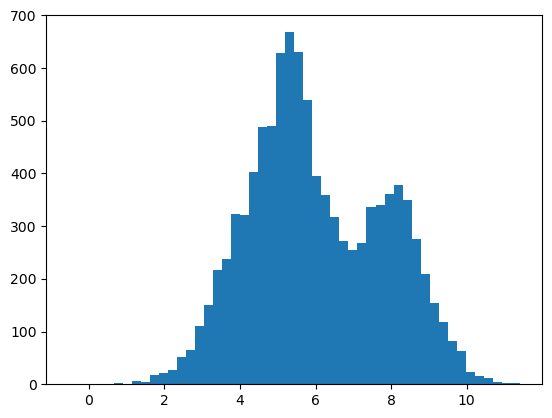

In [7]:
gmm_samples = get_gmm_samples()
plt.hist(gmm_samples, bins=50)

In [18]:
from scipy import stats

def get_gmm_pdf(
    x,
    weights = [0.33, 0.54, 0.13],
    means = [8.09, 5.35, 3.75],
    sigmas = [1.06, 0.89, 0.39]
):
    res = []
    for x_ in x:
        res.append(np.sum([
            weights[i] * stats.norm.pdf(x_, loc=means[i], scale=sigmas[i])
            for i in range(len(weights))
        ]))
    return res
    

In [19]:
get_gmm_pdf(np.array([8, 10]))

[0.12662793481509543, 0.024495731561877676]

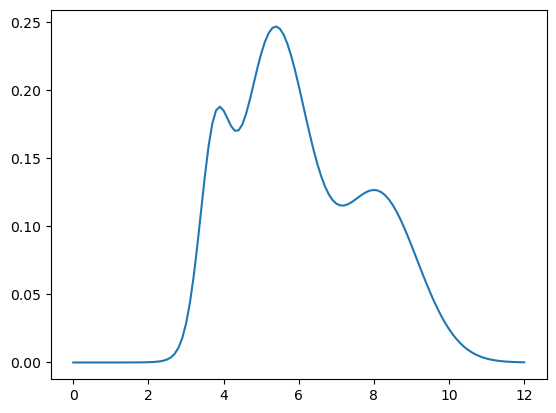

In [21]:
x = np.linspace(0, 12, 121)
gmm_pdf = get_gmm_pdf(x)
plt.plot(x, gmm_pdf)

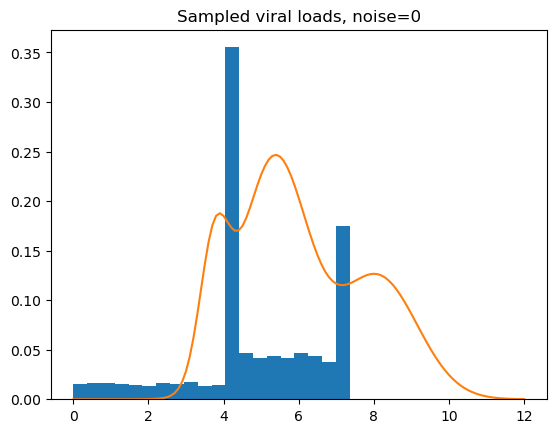

In [28]:
NOISE=0

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
    peak_plateau_height_bounds=(7.359, 7.359), # fix this for now
    tail_height_bounds=(4.106, 4.106),
    num_samples=5000,
    noise=NOISE
)
    
plt.hist(sampled_vls, bins=20, weights = np.ones(len(sampled_vls)) / len(sampled_vls))
plt.title(f"Sampled viral loads, noise={NOISE}")

plt.plot(x, gmm_pdf)

# Tune a population with symptomatic and asymptomatic to match GMM

'\n    weights = [0.33, 0.54, 0.13],\n    means = [8.09, 5.35, 3.75],\n    sigmas = [1.06, 0.89, 0.39]\n'

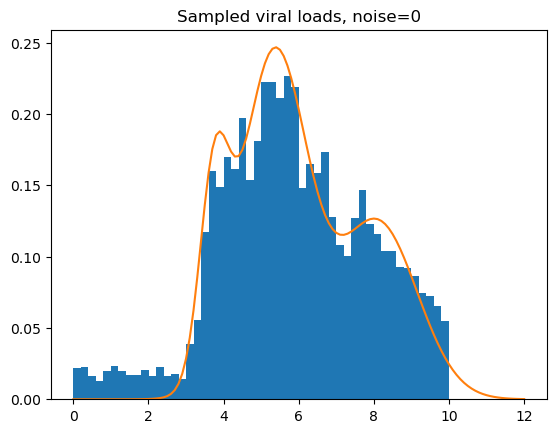

In [70]:
NOISE=0

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(1,3), (4,6), (11.5, 13.5), (15,17)],
    peak_plateau_height_bounds=(7.5,10),
    tail_height_bounds=(3.5, 6),
    num_samples=7000,
    noise=NOISE
)

sampled_vls_, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(1,3), (4,6), (11,11), (11,11)],
    peak_plateau_height_bounds=(5,7),
    tail_height_bounds=(3,3.5),
    num_samples=3000,
    noise=NOISE
)
    
plt.hist(
    sampled_vls + sampled_vls_, bins=50, 
    density=True,
    # weights = np.ones(len(sampled_vls)) / len(sampled_vls)
)
plt.title(f"Sampled viral loads, noise={NOISE}")

plt.plot(x, gmm_pdf)

# GMM
"""
    weights = [0.33, 0.54, 0.13],
    means = [8.09, 5.35, 3.75],
    sigmas = [1.06, 0.89, 0.39]
"""

Text(0.5, 1.0, 'Sampled viral loads, noise=0.8')

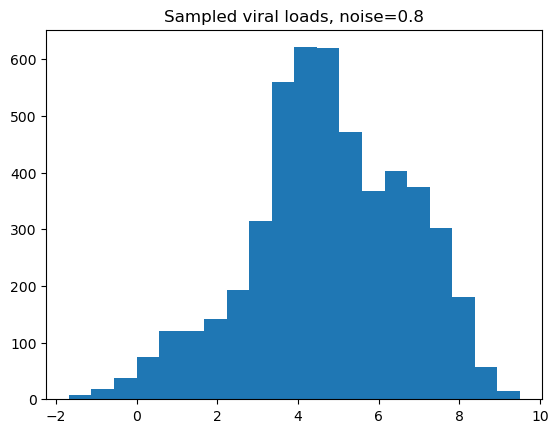

In [50]:
NOISE=0.8

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
    peak_plateau_height_bounds=(7.359, 7.359), # fix this for now
    tail_plateau_height=4.106,
    num_samples=5000,
    noise=NOISE
)
    
plt.hist(sampled_vls, bins=20)
plt.title(f"Sampled viral loads, noise={NOISE}")


Text(0.5, 1.0, 'Sampled viral loads, noise=0.5')

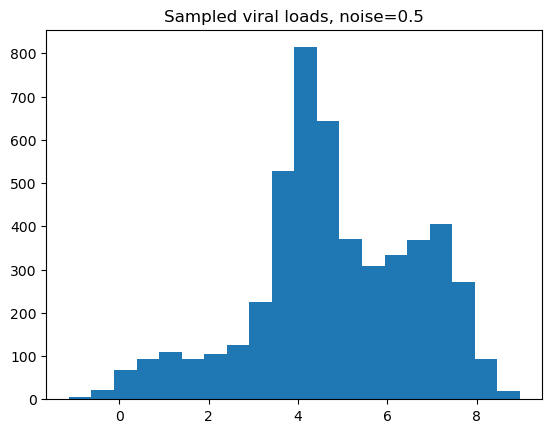

In [52]:
NOISE=0.5

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
    peak_plateau_height_bounds=(7.359, 7.359), # fix this for now
    tail_plateau_height=4.106,
    num_samples=5000,
    noise=NOISE
)
    
plt.hist(sampled_vls, bins=20)
plt.title(f"Sampled viral loads, noise={NOISE}")

Text(0.5, 1.0, 'Sampled viral loads, noise=0.2')

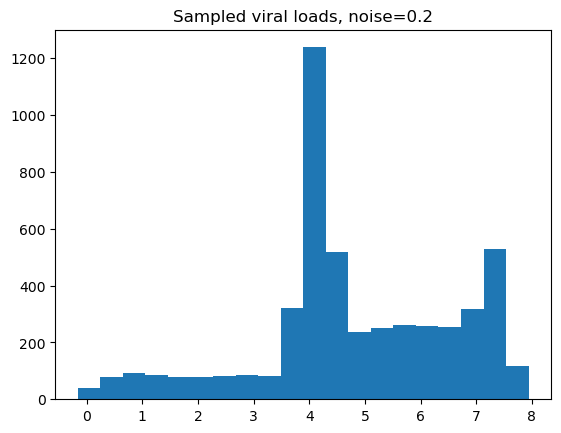

In [53]:
NOISE=0.2

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
    peak_plateau_height_bounds=(7.359, 7.359), # fix this for now
    tail_plateau_height=4.106,
    num_samples=5000,
    noise=NOISE
)
    
plt.hist(sampled_vls, bins=20)
plt.title(f"Sampled viral loads, noise={NOISE}")

## Thinking about tuning parameters based on likelihood

In [109]:
def get_gmm_likelihood(
    vls,
    weights = [0.33, 0.54, 0.13],
    means = [8.09, 5.35, 3.75],
    sigmas = [1.06, 0.89, 0.39]
):
    r"""
    Return the log likelihood of a given set of values in `vls` 
    under the Gaussian mixture model with the given parameters.
    """

    all_likelihoods = np.zeros_like(vls)
    
    for i in range(len(weights)):
        weight = weights[i]
        mean = means[i]
        sigma = sigmas[i]

        likelihood = weight / sigma * np.exp(-0.5 * (vls - mean)**2 / sigma**2)
        all_likelihoods += likelihood
    total_likelihood = np.sum(np.log(all_likelihoods))
    # total_likelihood = np.product(all_likelihoods)
    
    return total_likelihood

### Try grid search on (peak height, tail height, noise) first, keeping the critical time points fixed

In [113]:
import itertools

np.random.seed(0)

peak_plateau_height_range = np.linspace(6, 8, 11)
tail_plateau_height_range = np.linspace(2, 4, 11)
noise_range = np.linspace(0.1, 1, 10)

configs = []
likelihoods = []

for peak_plateau_height, tail_plateau_height, noise in \
    itertools.product(peak_plateau_height_range, tail_plateau_height_range, noise_range):
    
    sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
        critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
        peak_plateau_height_bounds=(peak_plateau_height, peak_plateau_height), # fix this for now
        tail_plateau_height=tail_plateau_height,
        num_samples=5000,
        noise=noise
    )

    configs.append((peak_plateau_height, tail_plateau_height, noise))
    likelihoods.append(get_gmm_likelihood(np.array(sampled_vls)))
    

(array([  8.,  59., 111., 106., 118., 119., 144., 186., 232., 127.]),
 array([-26063.83405997, -24410.99756791, -22758.16107585, -21105.32458379,
        -19452.48809173, -17799.65159967, -16146.81510761, -14493.97861556,
        -12841.1421235 , -11188.30563144,  -9535.46913938]),
 <BarContainer object of 10 artists>)

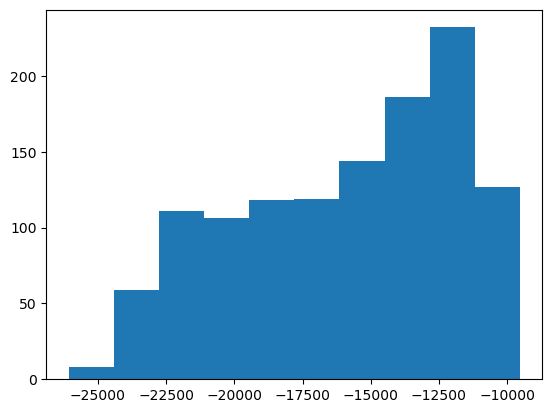

In [114]:
plt.hist(likelihoods)

In [115]:
likelihoods_arr = np.array(likelihoods)
inds = likelihoods_arr.argsort()[-10:]

for ind_ in inds:
    print(configs[ind_], likelihoods[ind_])

(7.0, 4.0, 0.1) -10043.398727128335
(8.0, 3.6, 0.1) -10041.329754545815
(7.8, 3.8, 0.2) -10031.743671735127
(7.8, 3.8, 0.1) -10005.987955880435
(8.0, 3.8, 0.30000000000000004) -10000.007517183847
(7.2, 4.0, 0.1) -9933.353220142671
(7.8, 4.0, 0.30000000000000004) -9806.016752510362
(8.0, 4.0, 0.30000000000000004) -9766.45512394643
(7.6, 3.8, 0.2) -9697.609603765986
(8.0, 4.0, 0.1) -9535.46913937933


In [116]:
configs[likelihoods.index(np.max(likelihoods))]

(8.0, 4.0, 0.1)

Text(0.5, 1.0, 'Sampled viral loads')

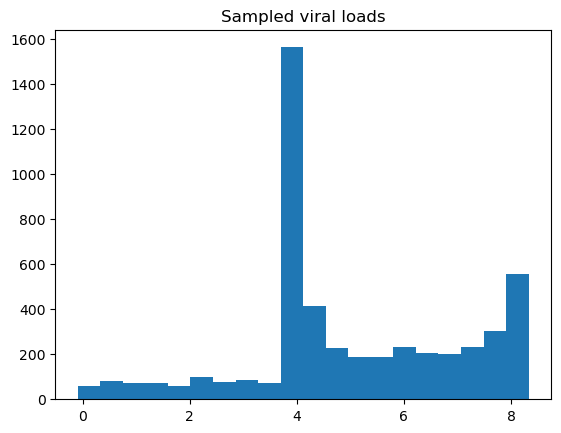

In [117]:
# what (8.0, 4.0, 0.1) looks like

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
    peak_plateau_height_bounds=(8,8), # fix this for now
    tail_plateau_height=4,
    num_samples=5000,
    noise=0.1
)
    
plt.hist(sampled_vls, bins=20)
plt.title(f"Sampled viral loads")

Text(0.5, 1.0, 'Sampled viral loads')

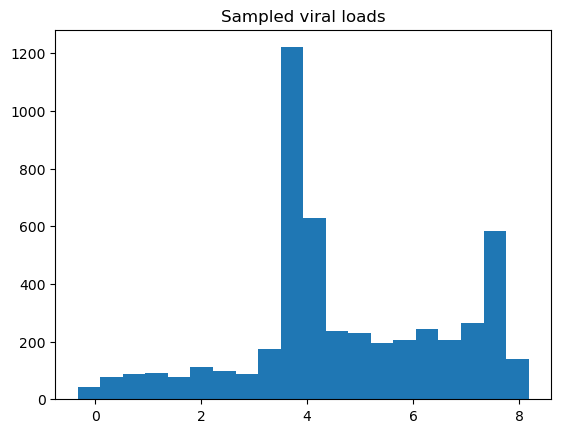

In [118]:
# trying out (7.6, 3.8, 0.2)

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
    peak_plateau_height_bounds=(7.6, 7.6), # fix this for now
    tail_plateau_height=3.8,
    num_samples=5000,
    noise=0.2
)
    
plt.hist(sampled_vls, bins=20)
plt.title(f"Sampled viral loads")

Text(0.5, 1.0, 'Sampled viral loads')

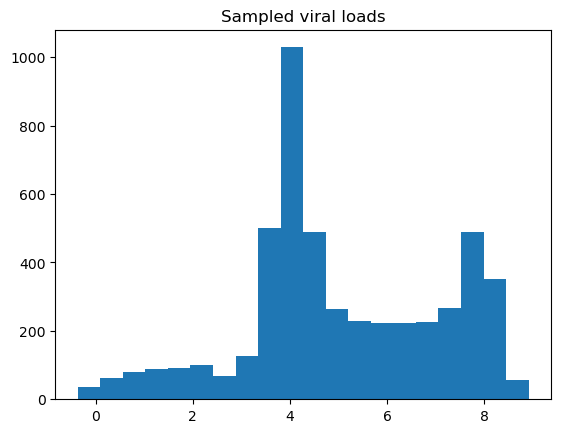

In [119]:
# (8.0, 4.0, 0.3)

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(5,5), (7,7), (11,11), (16,16)],
    peak_plateau_height_bounds=(8,8), # fix this for now
    tail_plateau_height=4,
    num_samples=5000,
    noise=0.3
)
    
plt.hist(sampled_vls, bins=20)
plt.title(f"Sampled viral loads")